# Hand motions classification using non-invasive EEG recordings
### by Cedric Simar and Antoine Passemiers
<hr/>

## Table of content

* [0 - Introduction](#introduction)
  * [0.1. Problem description](#problem-description)


* [1 - Preprocessing](#preprocessing)
  * [1.1. Import useful libraries](#import-libraries)
  * [1.2. Load the data](#load-data)
  * [1.3. Band-pass filtering](#band-pass-filtering)
  * [1.4. Downsampling](#downsampling)


* [2. Riemannian-based kernel trick](#kernel-trick)


* [3. Validating the models](#models)


* [4. Bibliography](#bibliography)

## Introduction <a class="anchor" id="introduction"></a>
<hr/>

### Problem description <a class="anchor" id="problem-description"></a>

In [3]:
from IPython.display import HTML
url = "https://www.youtube.com/embed/y3_Izuop2gY?rel=0&amp;controls=0&amp;showinfo=0"
HTML('<iframe style="display:block" width="560" height="315" src="%s" frameborder="0" allowfullscreen></iframe>' % url)

## Preprocessing <a class="anchor" id="preprocessing"></a>
<hr/>

### Import useful libraries <a class="anchor" id="import-libraries"></a>

In [16]:
%load_ext Cython

import os
import gc
import time
import scipy.linalg
import scipy.signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Load the data <a class="anchor" id="load-data"></a>

TODO Cedric: descriptions (electrodes, multi-labels, échantillonage, tout ça tout ça)

<figure style="text-align:center;">
  <img src="imgs/EEG_Electrode_Numbering.jpg" style="width:450px;">
  <figcaption> Source: [Kaggle](#bib-kaggle) </figcaption>
</figure>

In [34]:
N_PATIENTS = 12
# Feature names
ELECTRODE_NAMES = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
# Label names
EVENT_NAMES = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']


def load_dataset(subject=-1, data_dir='', with_test_data=True):
    """
    Parameters
    ----------
    subject: int, list, np.ndarray
        Either a subject id or a sequence of ids. If subject is set to -1,
        the data from all patients will be returned
    data_dir: str
        path to the folder where train/ and test/ subfolders are located
    with_test_data: bool
        If set to true, test series/set will be returned
    
    Return
    ------
    If with_test_data: List of couples of dataframes
    Otherwise: List of dataframes
    """
    if type(subject) == int:
        subject_ids = list(range(1, N_PATIENTS+1)) if subject == -1 else [subject]
    else:
        subject_ids = list(subject)
    print("Loading dataset...")
    subjects_data = list()
    for subject_id in subject_ids:
        subject_train_data = list()
        for series_id in range(1, 9):
            print("\tSeries %i of subject %i" % (series_id, subject_id))
            train_data_filename = os.path.join(
                data_dir, 'train/subj%s_series%s_data.csv' % (subject_id, series_id))
            events_filename = os.path.join(
                data_dir, 'train/subj%s_series%s_events.csv' % (subject_id, series_id))
            train_series, events = pd.read_csv(train_data_filename), pd.read_csv(events_filename)
            train_series[EVENT_NAMES] = events[EVENT_NAMES]
            subject_train_data.append(train_series)
        if with_test_data:
            subject_test_data = list()
            for series_id in range(9, 11):
                test_data_filename = os.path.join(
                    data_dir, 'test/subj%s_series%s_data.csv' % (subject_id, series_id))
                subject_test_data.append(pd.read_csv(test_data_filename))
            subjects_data.append((subject_train_data, subject_test_data))
        else:
            subjects_data.append(subject_train_data)
    return subjects_data

In [42]:
dataset = load_dataset(subject=1, data_dir='data')[0] # Take first list since we consider only patient number 1

training_set, test_set = dataset
training_set = pd.concat(training_set)

X_train = np.asarray(training_set[ELECTRODE_NAMES], dtype=np.int16)
Y_train = np.asarray(training_set[EVENT_NAMES], dtype=np.int16)
X_test = np.asarray(training_set[ELECTRODE_NAMES], dtype=np.int16)
Y_test = np.asarray(training_set[EVENT_NAMES], dtype=np.int16)

Loading dataset...
	Series 1 of subject 1
	Series 2 of subject 1
	Series 3 of subject 1
	Series 4 of subject 1
	Series 5 of subject 1
	Series 6 of subject 1
	Series 7 of subject 1
	Series 8 of subject 1


### Band-pass filtering <a class="anchor" id="band-pass-filtering"></a>

To avoid creating potential aliasing effects, we apply necessary spectral filters on the raw signals before to downsample them.

In [43]:
class BandPassFilter:
    
    def __init__(self, lowcut_freq, highcut_freq, sampling_freq, order=5):
        self.nyquist_freq = sampling_freq / 2.
        lower_bound = lowcut_freq / self.nyquist_freq
        upper_bound = highcut_freq / self.nyquist_freq
        self.b, self.a = scipy.signal.butter(order, [lower_bound, upper_bound], btype='band')
    
    def lfilter(self, signal):
        return scipy.signal.lfilter(self.b, self.a, signal, axis=0)

In [44]:
# Sampling frequency: 500 Hz (from the dataset description)
# Filter band of interest (from Barachant et al.): 8 Hz to 35 Hz (µ and β frequency bands)
bandpass = BandPassFilter(8, 35, 500)

X_train = bandpass.lfilter(X_train)
X_test = bandpass.lfilter(X_test)

### Downsampling <a class="anchor" id="downsampling"></a>

In [45]:
# 500 Hz -> 125 Hz
X_train, Y_train = X_train[::4], Y_train[::4]
X_test, Y_test = X_test[::4], Y_test[::4]

## Riemannian-based kernel trick <a class="anchor" id="kernel-trick"></a>

In [46]:
%%cython

import numpy as np
cimport numpy as cnp
cnp.import_array()

def extract_cov_matrices(cnp.float_t[:, :] data, Py_ssize_t w):
    cdef Py_ssize_t n_features = data.shape[1]
    cdef cnp.float_t[:, :, :] sigmas = np.empty((data.shape[0], n_features, n_features), dtype=np.float)
    cdef cnp.float_t[:] means = np.asarray(np.mean(np.asarray(data)[:w, :], axis=0), dtype=np.float)
    cdef cnp.float_t[:, :] last_sigma = np.cov(np.asarray(data)[:w, :].T)
    np_sigmas = np.asarray(sigmas)
    np_sigmas[:w, :, :] = np.repeat(np.asarray(last_sigma).reshape((1, n_features, n_features), order='C'), w, axis=0)
    cdef Py_ssize_t i, j
    with nogil:
        for i in range(w, data.shape[0]):
            with gil:
                # TODO: make it faster
                np_sigmas[i, :, :] = np.cov(np.asarray(data)[i-w:i].T)
    return np.asarray(sigmas)

In [47]:
X_train = X_train[:10000].astype(np.float)
Y_train = Y_train[:10000].astype(np.float)

cov_matrices = extract_cov_matrices(X_train, 150)

In [48]:
def lmap(Cp, sqrtC, sqrtCinv):
    return sqrtC * scipy.linalg.logm(sqrtCinv * Cp * sqrtCinv) * sqrtC

def emap(Cp, sqrtC, sqrtCinv):
    return sqrtC * scipy.linalg.expm(sqrtCinv * Cp * sqrtCinv) * sqrtC

def hlmap(Cp, sqrtCinv):
    return scipy.linalg.logm(sqrtCinv * Cp * sqrtCinv)

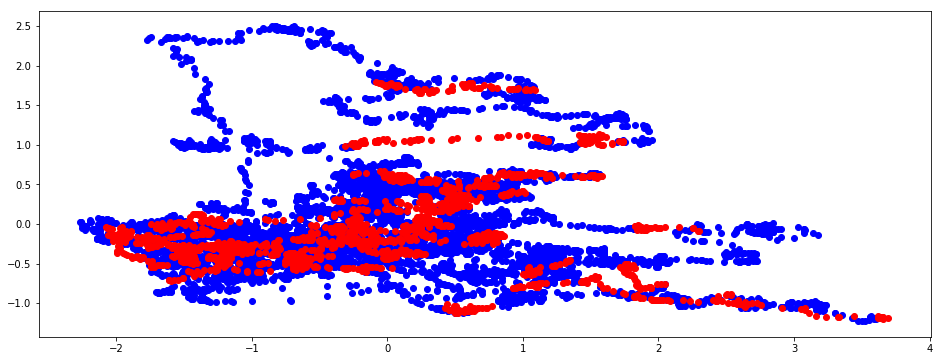

In [49]:
print("This step might take a couple a minutes...")

sqrtC = scipy.linalg.sqrtm(cov_matrices[0])
sqrtCinv = scipy.linalg.inv(sqrtC)
H = cov_matrices
H = np.asarray([hlmap(h, sqrtCinv) for h in H])

pca = PCA(n_components=2)
points = pca.fit_transform(H.reshape(len(H), -1))

labels = Y_train
nothing = labels.sum(axis=1) == 0
something = labels.sum(axis=1) > 0

plt.figure(figsize=(16, 6))
plt.scatter(points[nothing, 0], points[nothing, 1], c='blue')
plt.scatter(points[something, 0], points[something, 1], c='red')
plt.show()

## Validating the models <a class="anchor" id="models"></a>
<hr/>

## Bibliography <a class="anchor" id="bibliography"></a>
<hr/>

* <span class="anchor" id="bib-riemann">
    [1] Classification of covariance matrices using a Riemannian-based kernel for BCI applications <br>
    Alexandre Barachant, Stéphane Bonnet, Marco Congedo, Christian Jutten <br>
    https://hal.archives-ouvertes.fr/file/index/docid/820475/filename/BARACHANT_Neurocomputing_ForHal.pdf <br>
  </span>
<br>

* <span class="anchor" id="bib-kaggle">
    [2] Grasp-and-Lift EEG Detection Kaggle Competition <br>
    https://www.kaggle.com/c/grasp-and-lift-eeg-detection <br>
  </span>
<br>